In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
data = yf.download(
    tickers = "ADANIPOWER.NS",
    start = "2021-06-10",
    end = "2021-06-11",
    interval = '1m',
    auto_adjust = True,
    threads = True
)

[*********************100%***********************]  1 of 1 completed


In [3]:
print(data)

                                 Open        High         Low       Close  \
Datetime                                                                    
2021-06-10 09:15:00+05:30  156.850006  163.850006  156.850006  162.100006   
2021-06-10 09:16:00+05:30  162.300003  162.350006  158.250000  160.500000   
2021-06-10 09:17:00+05:30  160.399994  162.699997  160.399994  162.149994   
2021-06-10 09:18:00+05:30  162.250000  163.000000  161.750000  162.300003   
2021-06-10 09:19:00+05:30  162.350006  162.399994  160.699997  161.600006   
...                               ...         ...         ...         ...   
2021-06-10 12:33:00+05:30  155.800003  155.800003  155.649994  155.649994   
2021-06-10 12:34:00+05:30  155.699997  155.750000  155.600006  155.750000   
2021-06-10 12:35:00+05:30  155.750000  155.800003  155.699997  155.750000   
2021-06-10 12:36:00+05:30  155.750000  155.949997  155.750000  155.949997   
2021-06-10 12:37:34+05:30  155.899994  155.899994  155.899994  155.899994   

In [4]:
data['Typical Price'] = data['High'] + data['Close'] + data['Low']
print(data['Typical Price'])

Datetime
2021-06-10 09:15:00+05:30    482.800018
2021-06-10 09:16:00+05:30    481.100006
2021-06-10 09:17:00+05:30    485.249985
2021-06-10 09:18:00+05:30    487.050003
2021-06-10 09:19:00+05:30    484.699997
                                ...    
2021-06-10 12:33:00+05:30    467.099991
2021-06-10 12:34:00+05:30    467.100006
2021-06-10 12:35:00+05:30    467.250000
2021-06-10 12:36:00+05:30    467.649994
2021-06-10 12:37:34+05:30    467.699982
Name: Typical Price, Length: 203, dtype: float64


In [5]:
price_array = np.array(data['Typical Price'])

In [6]:
training_period = 20
feature_price_list = []
label_price_list = []
for i in range(training_period, len(price_array)):
    feature_price_list.append(price_array[i - training_period: i])
    label_price_list.append(price_array[i])

In [7]:
def lin_reg(training_array):
    n = len(training_array)
    sum_x2 = n*(n+1)*(2*n+1)/6
    sum_x = n*(n+1)/2
    sum_x_squared = sum_x**2
    sum_y = np.sum(training_array)
    sum_xy = 0
    for i in range(n):
        sum_xy += training_array[i]*(i+1)
    
    b = ((n*sum_xy) - (sum_x*sum_y))/((n*sum_x2) - sum_x_squared)
    a = (sum_y - b*sum_x)/n
    
    pred = b*(n+1) + a
    return pred
    

In [8]:
df_weights = pd.DataFrame(index = [("Test" + str(i+1)) for i in range(len(label_price_list))], columns = [str(i) for i in range(2,training_period+1)])
ctr = 1
for feat,lbl in zip(feature_price_list, label_price_list):
    r2_list = []
    for i in range(2, training_period+1):
        r = lbl - lin_reg(feat[-i:])
        r2 = r**2
        r2_list.append(r2)
    max_r2 = max(r2_list)
    weights_list = []
    for i in r2_list:
        weights_list.append(max_r2 - i)
    sum_weights = sum(weights_list)
    for i in range(len(weights_list)):
        weights_list[i] = weights_list[i]*100/sum_weights
        df_weights.loc["Test" + str(ctr), str(i+2)] = weights_list[i]
    ctr += 1
final_weights_list = [(i,df_weights.mean(axis=0)[str(i)]) for i in range(2, training_period+1)]
print(final_weights_list)

[(2, 7.097805637934813), (3, 6.692970621774875), (4, 6.206573647250047), (5, 5.766203279337563), (6, 5.516581250640095), (7, 5.440342862701816), (8, 5.427918338436363), (9, 5.412709470470323), (10, 5.393030026009776), (11, 5.336770586510046), (12, 5.261559679924135), (13, 5.21306817042357), (14, 5.158529617573441), (15, 5.024996248239596), (16, 4.790386914110455), (17, 4.503071990288433), (18, 4.20403551200945), (19, 3.9251256863844013), (20, 3.6283204599807997)]


In [9]:
pred_list = []
price_list = []
mean_rev = []
for x in range(len(label_price_list)):
    pred = 0
    sum_of_weights = sum([i[1] for i in final_weights_list])
    for i,j in final_weights_list:
        pred += (lin_reg(feature_price_list[x][-i:]*j))/sum_of_weights
    pred_list.append(pred)
    price_list.append(label_price_list[x])
    mean_rev.append(label_price_list[x] - pred)
std_up = np.std(np.array(mean_rev))*2
std_down = -np.std(np.array(mean_rev))*2

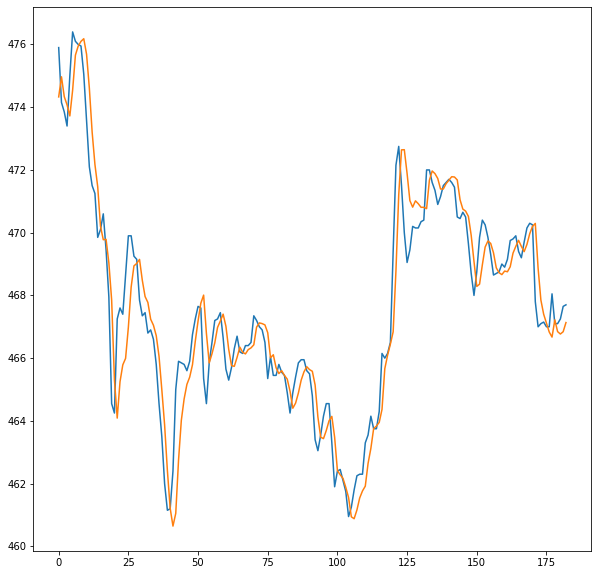

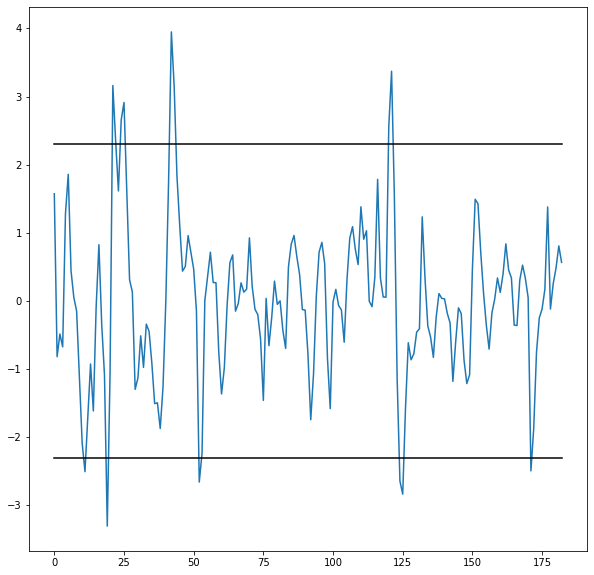

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 10))
ax1 = plt.subplot()
plt.plot(range(len(price_list)), price_list)
plt.plot(range(len(pred_list)), pred_list)

figure(figsize=(10, 10))
ax2 = plt.subplot()
plt.plot(range(len(price_list)),mean_rev)
plt.plot(range(len(price_list)), [std_up for i in range(len(price_list))], color = 'black')
plt.plot(range(len(price_list)), [std_down for i in range(len(price_list))], color = 'black')

plt.show()